# NOTE: Adapted from "Interpretability in the Wild: a Circuit for Indirect Object Identification in {GPT}-2 Small" (Kevin Ro Wang, Alexandre Variengien, Arthur Conmy, Buck Shlegeris, and Jacob Steinhardt. Interpretability in the wild: a circuit for indirect object identification in GPT-2 small. In The Eleventh International Conference on Learning Representations, 2023. URL https: //openreview.net/forum?id=NpsVSN6o4ul)

In [ ]:
import io
from logging import warning
from typing import Union, List
from site import PREFIXES
import warnings
import torch
import numpy as np
from tqdm import tqdm
import pandas as pd
from transformers import AutoTokenizer
import random
random.seed(42)
import re
import matplotlib.pyplot as plt
import copy

NAMES = [
    "Michael",
    "Christopher",
    "Jessica",
    "Matthew",
    "Ashley",
    "Jennifer",
    "Joshua",
    "Amanda",
    "Daniel",
    "David",
    "James",
    "Robert",
    "John",
    "Joseph",
    "Andrew",
    "Ryan",
    "Brandon",
    "Jason",
    "Justin",
    "Sarah",
    "William",
    "Jonathan",
    "Stephanie",
    "Brian",
    "Nicole",
    "Nicholas",
    "Anthony",
    "Heather",
    "Eric",
    "Elizabeth",
    "Adam",
    "Megan",
    "Melissa",
    "Kevin",
    "Steven",
    "Thomas",
    "Timothy",
    "Christina",
    "Kyle",
    "Rachel",
    "Laura",
    "Lauren",
    "Amber",
    "Brittany",
    "Danielle",
    "Richard",
    "Kimberly",
    "Jeffrey",
    "Amy",
    "Crystal",
    "Michelle",
    "Tiffany",
    "Jeremy",
    "Benjamin",
    "Mark",
    "Emily",
    "Aaron",
    "Charles",
    "Rebecca",
    "Jacob",
    "Stephen",
    "Patrick",
    "Sean",
    "Erin",
    "Jamie",
    "Kelly",
    "Samantha",
    "Nathan",
    "Sara",
    "Dustin",
    "Paul",
    "Angela",
    "Tyler",
    "Scott",
    "Katherine",
    "Andrea",
    "Gregory",
    "Erica",
    "Mary",
    "Travis",
    "Lisa",
    "Kenneth",
    "Bryan",
    "Lindsey",
    "Kristen",
    "Jose",
    "Alexander",
    "Jesse",
    "Katie",
    "Lindsay",
    "Shannon",
    "Vanessa",
    "Courtney",
    "Christine",
    "Alicia",
    "Cody",
    "Allison",
    "Bradley",
    "Samuel",
]

ABC_TEMPLATES = [
    "Then, [A], [B] and [C] went to the [PLACE]. [B] and [C] gave a [OBJECT] to [A]",
    "Afterwards [A], [B] and [C] went to the [PLACE]. [B] and [C] gave a [OBJECT] to [A]",
    "When [A], [B] and [C] arrived at the [PLACE], [B] and [C] gave a [OBJECT] to [A]",
    "Friends [A], [B] and [C] went to the [PLACE]. [B] and [C] gave a [OBJECT] to [A]",
]

BAC_TEMPLATES = [
    template.replace("[B]", "[A]", 1).replace("[A]", "[B]", 1)
    for template in ABC_TEMPLATES
]

BABA_TEMPLATES = [
    "Then, [B] and [A] went to the [PLACE]. [B] gave a [OBJECT] to [A]",
    "Then, [B] and [A] had a lot of fun at the [PLACE]. [B] gave a [OBJECT] to [A]",
    "Then, [B] and [A] were working at the [PLACE]. [B] decided to give a [OBJECT] to [A]",
    "Then, [B] and [A] were thinking about going to the [PLACE]. [B] wanted to give a [OBJECT] to [A]",
    "Then, [B] and [A] had a long argument, and afterwards [B] said to [A]",
    "After [B] and [A] went to the [PLACE], [B] gave a [OBJECT] to [A]",
    "When [B] and [A] got a [OBJECT] at the [PLACE], [B] decided to give it to [A]",
    "When [B] and [A] got a [OBJECT] at the [PLACE], [B] decided to give the [OBJECT] to [A]",
    "While [B] and [A] were working at the [PLACE], [B] gave a [OBJECT] to [A]",
    "While [B] and [A] were commuting to the [PLACE], [B] gave a [OBJECT] to [A]",
    "After the lunch, [B] and [A] went to the [PLACE]. [B] gave a [OBJECT] to [A]",
    "Afterwards, [B] and [A] went to the [PLACE]. [B] gave a [OBJECT] to [A]",
    "Then, [B] and [A] had a long argument. Afterwards [B] said to [A]",
    "The [PLACE] [B] and [A] went to had a [OBJECT]. [B] gave it to [A]",
    "Friends [B] and [A] found a [OBJECT] at the [PLACE]. [B] gave it to [A]",
]

BABA_LONG_TEMPLATES = [
    "Then in the morning, [B] and [A] went to the [PLACE]. [B] gave a [OBJECT] to [A]",
    "Then in the morning, [B] and [A] had a lot of fun at the [PLACE]. [B] gave a [OBJECT] to [A]",
    "Then in the morning, [B] and [A] were working at the [PLACE]. [B] decided to give a [OBJECT] to [A]",
    "Then in the morning, [B] and [A] were thinking about going to the [PLACE]. [B] wanted to give a [OBJECT] to [A]",
    "Then in the morning, [B] and [A] had a long argument, and afterwards [B] said to [A]",
    "After taking a long break [B] and [A] went to the [PLACE], [B] gave a [OBJECT] to [A]",
    "When soon afterwards [B] and [A] got a [OBJECT] at the [PLACE], [B] decided to give it to [A]",
    "When soon afterwards [B] and [A] got a [OBJECT] at the [PLACE], [B] decided to give the [OBJECT] to [A]",
    "While spending time together [B] and [A] were working at the [PLACE], [B] gave a [OBJECT] to [A]",
    "While spending time together [B] and [A] were commuting to the [PLACE], [B] gave a [OBJECT] to [A]",
    "After the lunch in the afternoon, [B] and [A] went to the [PLACE]. [B] gave a [OBJECT] to [A]",
    "Afterwards, while spending time together [B] and [A] went to the [PLACE]. [B] gave a [OBJECT] to [A]",
    "Then in the morning afterwards, [B] and [A] had a long argument. Afterwards [B] said to [A]",
    "The local big [PLACE] [B] and [A] went to had a [OBJECT]. [B] gave it to [A]",
    "Friends separated at birth [B] and [A] found a [OBJECT] at the [PLACE]. [B] gave it to [A]",
]

BABA_LATE_IOS = [
    "Then, [B] and [A] went to the [PLACE]. [B] gave a [OBJECT] to [A]",
    "Then, [B] and [A] had a lot of fun at the [PLACE]. [B] gave a [OBJECT] to [A]",
    "Then, [B] and [A] were working at the [PLACE]. [B] decided to give a [OBJECT] to [A]",
    "Then, [B] and [A] were thinking about going to the [PLACE]. [B] wanted to give a [OBJECT] to [A]",
    "Then, [B] and [A] had a long argument and after that [B] said to [A]",
    "After the lunch, [B] and [A] went to the [PLACE]. [B] gave a [OBJECT] to [A]",
    "Afterwards, [B] and [A] went to the [PLACE]. [B] gave a [OBJECT] to [A]",
    "Then, [B] and [A] had a long argument. Afterwards [B] said to [A]",
]

BABA_EARLY_IOS = [
    "Then [B] and [A] went to the [PLACE], and [B] gave a [OBJECT] to [A]",
    "Then [B] and [A] had a lot of fun at the [PLACE], and [B] gave a [OBJECT] to [A]",
    "Then [B] and [A] were working at the [PLACE], and [B] decided to give a [OBJECT] to [A]",
    "Then [B] and [A] were thinking about going to the [PLACE], and [B] wanted to give a [OBJECT] to [A]",
    "Then [B] and [A] had a long argument, and after that [B] said to [A]",
    "After the lunch [B] and [A] went to the [PLACE], and [B] gave a [OBJECT] to [A]",
    "Afterwards [B] and [A] went to the [PLACE], and [B] gave a [OBJECT] to [A]",
    "Then [B] and [A] had a long argument, and afterwards [B] said to [A]",
]

TEMPLATES_VARIED_MIDDLE = [
    "",
]

# no end of texts, GPT-2 small wasn't trained this way (ask Arthur)
# warnings.warn("Adding end of text prefixes!")
# for TEMPLATES in [BABA_TEMPLATES, BABA_EARLY_IOS, BABA_LATE_IOS]:
#     for i in range(len(TEMPLATES)):
#         TEMPLATES[i] = "<|endoftext|>" + TEMPLATES[i]

ABBA_TEMPLATES = BABA_TEMPLATES[:]
ABBA_LATE_IOS = BABA_LATE_IOS[:]
ABBA_EARLY_IOS = BABA_EARLY_IOS[:]

for TEMPLATES in [ABBA_TEMPLATES, ABBA_LATE_IOS, ABBA_EARLY_IOS]:
    for i in range(len(TEMPLATES)):
        first_clause = True
        for j in range(1, len(TEMPLATES[i]) - 1):
            if TEMPLATES[i][j - 1 : j + 2] == "[B]" and first_clause:
                TEMPLATES[i] = TEMPLATES[i][:j] + "A" + TEMPLATES[i][j + 1 :]
            elif TEMPLATES[i][j - 1 : j + 2] == "[A]" and first_clause:
                first_clause = False
                TEMPLATES[i] = TEMPLATES[i][:j] + "B" + TEMPLATES[i][j + 1 :]

VERBS = [" tried", " said", " decided", " wanted", " gave"]
PLACES = [
    "store",
    "garden",
    "restaurant",
    "school",
    "hospital",
    "office",
    "house",
    "station",
]
OBJECTS = [
    "ring",
    "kiss",
    "bone",
    "basketball",
    "computer",
    "necklace",
    "drink",
    "snack",
]

ANIMALS = [
    "dog",
    "cat",
    "snake",
    "elephant",
    "beetle",
    "hippo",
    "giraffe",
    "tiger",
    "husky",
    "lion",
    "panther",
    "whale",
    "dolphin",
    "beaver",
    "rabbit",
    "fox",
    "lamb",
    "ferret",
]


def multiple_replace(dict, text):
    # from: https://stackoverflow.com/questions/15175142/how-can-i-do-multiple-substitutions-using-regex
    # Create a regular expression from the dictionary keys
    regex = re.compile("(%s)" % "|".join(map(re.escape, dict.keys())))

    # For each match, look-up corresponding value in dictionary
    return regex.sub(lambda mo: dict[mo.string[mo.start() : mo.end()]], text)


def iter_sample_fast(iterable, samplesize):
    results = []
    # Fill in the first samplesize elements:
    try:
        for _ in range(samplesize):
            results.append(next(iterable))
    except StopIteration:
        raise ValueError("Sample larger than population.")
    random.shuffle(results)  # Randomize their positions

    return results


NOUNS_DICT = NOUNS_DICT = {"[PLACE]": PLACES, "[OBJECT]": OBJECTS}


def gen_prompt_uniform(
    templates, names, nouns_dict, N, symmetric, prefixes=None, abc=False
):
    nb_gen = 0
    ioi_prompts = []
    while nb_gen < N:
        temp = random.choice(templates)
        temp_id = templates.index(temp)
        name_1 = ""
        name_2 = ""
        name_3 = ""
        while len(set([name_1, name_2, name_3])) < 3:
            name_1 = random.choice(names)
            name_2 = random.choice(names)
            name_3 = random.choice(names)

        nouns = {}
        ioi_prompt = {}
        for k in nouns_dict:
            nouns[k] = random.choice(nouns_dict[k])
            ioi_prompt[k] = nouns[k]
        prompt = temp
        for k in nouns_dict:
            prompt = prompt.replace(k, nouns[k])

        if prefixes is not None:
            L = random.randint(30, 40)
            pref = ".".join(random.choice(prefixes).split(".")[:L])
            pref += "<|endoftext|>"
        else:
            pref = ""

        prompt1 = prompt.replace("[A]", name_1)
        prompt1 = prompt1.replace("[B]", name_2)
        if abc:
            prompt1 = prompt1.replace("[C]", name_3)
        prompt1 = pref + prompt1
        ioi_prompt["text"] = prompt1
        ioi_prompt["IO"] = name_1
        ioi_prompt["S"] = name_2
        ioi_prompt["TEMPLATE_IDX"] = temp_id
        ioi_prompts.append(ioi_prompt)
        if abc:
            ioi_prompts[-1]["C"] = name_3

        nb_gen += 1

        if symmetric and nb_gen < N:
            prompt2 = prompt.replace("[A]", name_2)
            prompt2 = prompt2.replace("[B]", name_1)
            prompt2 = pref + prompt2
            ioi_prompts.append(
                {"text": prompt2, "IO": name_2, "S": name_1, "TEMPLATE_IDX": temp_id}
            )
            nb_gen += 1
    return ioi_prompts


def gen_flipped_prompts(prompts, names, flip=("S2", "IO")):
    """_summary_

    Args:
        prompts (List[D]): _description_
        flip (tuple, optional): First element is the string to be replaced, Second is what to replace with. Defaults to ("S2", "IO").

    Returns:
        _type_: _description_
    """
    flipped_prompts = []

    for prompt in prompts:
        t = prompt["text"].split(" ")
        prompt = prompt.copy()
        if flip[0] == "S2":
            if flip[1] == "IO":
                t[len(t) - t[::-1].index(prompt["S"]) - 1] = prompt["IO"]
                temp = prompt["IO"]
                prompt["IO"] = prompt["S"]
                prompt["S"] = temp
            elif flip[1] == "RAND":
                rand_name = names[np.random.randint(len(names))]
                while rand_name == prompt["IO"] or rand_name == prompt["S"]:
                    rand_name = names[np.random.randint(len(names))]
                t[len(t) - t[::-1].index(prompt["S"]) - 1] = rand_name
            else:
                raise ValueError("Invalid flip[1] value")

        elif flip[0] == "IO":
            if flip[1] == "RAND":
                rand_name = names[np.random.randint(len(names))]
                while rand_name == prompt["IO"] or rand_name == prompt["S"]:
                    rand_name = names[np.random.randint(len(names))]

                t[t.index(prompt["IO"])] = rand_name
                t[t.index(prompt["IO"])] = rand_name
                prompt["IO"] = rand_name
            elif flip[1] == "ANIMAL":
                rand_animal = ANIMALS[np.random.randint(len(ANIMALS))]
                t[t.index(prompt["IO"])] = rand_animal
                prompt["IO"] = rand_animal
                # print(t)
            elif flip[1] == "S1":
                io_index = t.index(prompt["IO"])
                s1_index = t.index(prompt["S"])
                io = t[io_index]
                s1 = t[s1_index]
                t[io_index] = s1
                t[s1_index] = io
            else:
                raise ValueError("Invalid flip[1] value")

        elif flip[0] in ["S", "S1"]:
            if flip[1] == "ANIMAL":
                new_s = ANIMALS[np.random.randint(len(ANIMALS))]
            if flip[1] == "RAND":
                new_s = names[np.random.randint(len(names))]
            t[t.index(prompt["S"])] = new_s
            if flip[0] == "S":  # literally just change the first S if this is S1
                t[len(t) - t[::-1].index(prompt["S"]) - 1] = new_s
                prompt["S"] = new_s
        elif flip[0] == "END":
            if flip[1] == "S":
                t[len(t) - t[::-1].index(prompt["IO"]) - 1] = prompt["S"]
        elif flip[0] == "PUNC":
            n = []

            # separate the punctuation from the words
            for i, word in enumerate(t):
                if "." in word:
                    n.append(word[:-1])
                    n.append(".")
                elif "," in word:
                    n.append(word[:-1])
                    n.append(",")
                else:
                    n.append(word)

            # remove punctuation, important that you check for period first
            if flip[1] == "NONE":
                if "." in n:
                    n[n.index(".")] = ""
                elif "," in n:
                    n[len(n) - n[::-1].index(",") - 1] = ""

            # remove empty strings
            while "" in n:
                n.remove("")

            # add punctuation back to the word before it
            while "," in n:
                n[n.index(",") - 1] += ","
                n.remove(",")

            while "." in n:
                n[n.index(".") - 1] += "."
                n.remove(".")

            t = n

        elif flip[0] == "C2":
            if flip[1] == "A":
                t[len(t) - t[::-1].index(prompt["C"]) - 1] = prompt["A"]
        elif flip[0] == "S+1":
            if t[t.index(prompt["S"]) + 1] == "and":
                t[t.index(prompt["S"]) + 1] = [
                    "with one friend named",
                    "accompanied by",
                ][np.random.randint(2)]
            else:
                t[t.index(prompt["S"]) + 1] = (
                    t[t.index(prompt["S"])]
                    + ", after a great day, "
                    + t[t.index(prompt["S"]) + 1]
                )
                del t[t.index(prompt["S"])]
        else:
            raise ValueError(f"Invalid flipper {flip[0]}")

        if "IO" in prompt:
            prompt["text"] = " ".join(t)
            flipped_prompts.append(prompt)
        else:
            flipped_prompts.append(
                {
                    "A": prompt["A"],
                    "B": prompt["B"],
                    "C": prompt["C"],
                    "text": " ".join(t),
                }
            )

    return flipped_prompts


# *Tok Idxs Methods


def get_name_idxs(prompts, tokenizer, idx_types=["IO", "S", "S2"], prepend_bos=False):
    name_idx_dict = dict((idx_type, []) for idx_type in idx_types)
    double_s2 = False
    for prompt in prompts:
        t = prompt["text"].split(" ")
        toks = tokenizer.tokenize(" ".join(t[:-1]))
        for idx_type in idx_types:
            if "2" in idx_type:
                idx = (
                    len(toks)
                    - toks[::-1].index(
                        tokenizer.tokenize(" " + prompt[idx_type[:-1]])[0]
                    )
                    - 1
                )
            else:
                idx = toks.index(tokenizer.tokenize(" " + prompt[idx_type])[0])
            name_idx_dict[idx_type].append(idx)
        if "S" in idx_types and "S2" in idx_types:
            if name_idx_dict["S"][-1] == name_idx_dict["S2"][-1]:
                double_s2 = True
    if double_s2:
        warnings.warn("S2 index has been computed as the same for S and S2")

    return [
        int(prepend_bos) + torch.tensor(name_idx_dict[idx_type])
        for idx_type in idx_types
    ]


def get_word_idxs(prompts, word_list, tokenizer):
    """Get the index of the words in word_list in the prompts. Exactly one of the word_list word has to be present in each prompt"""
    idxs = []
    tokenized_words = [
        tokenizer.decode(tokenizer(word)["input_ids"][0]) for word in word_list
    ]
    for pr_idx, prompt in enumerate(prompts):
        toks = [
            tokenizer.decode(t)
            for t in tokenizer(prompt["text"], return_tensors="pt", padding=True)[
                "input_ids"
            ][0]
        ]
        idx = None
        for i, w_tok in enumerate(tokenized_words):
            if word_list[i] in prompt["text"]:
                try:
                    idx = toks.index(w_tok)
                    if toks.count(w_tok) > 1:
                        idx = len(toks) - toks[::-1].index(w_tok) - 1
                except:
                    idx = toks.index(w_tok)
                    # raise ValueError(toks, w_tok, prompt["text"])
        if idx is None:
            raise ValueError(f"Word {word_list} and {i} not found {prompt}")
        idxs.append(idx)
    return torch.tensor(idxs)


def get_end_idxs(prompts, tokenizer, name_tok_len=1, prepend_bos=False, toks=None):
    # toks = torch.Tensor(tokenizer([prompt["text"] for prompt in prompts], padding=True).input_ids).type(torch.int)
    relevant_idx = int(prepend_bos)
    # if the sentence begins with an end token
    # AND the model pads at the end with the same end token,
    # then we need make special arrangements

    pad_token_id = tokenizer.pad_token_id

    end_idxs_raw = []
    for i in range(toks.shape[0]):
        if pad_token_id not in toks[i][1:]:
            end_idxs_raw.append(toks.shape[1])
            continue
        nonzers = (toks[i] == pad_token_id).nonzero()
        try:
            nonzers = nonzers[relevant_idx]
        except:
            print(toks[i])
            print(nonzers)
            print(relevant_idx)
            print(i)
            raise ValueError("Something went wrong")
        nonzers = nonzers[0]
        nonzers = nonzers.item()
        end_idxs_raw.append(nonzers)
    end_idxs = torch.tensor(end_idxs_raw)
    end_idxs = end_idxs - 1 - name_tok_len

    for i in range(toks.shape[0]):
        assert toks[i][end_idxs[i] + 1] != 0 and (
            toks.shape[1] == end_idxs[i] + 2 or toks[i][end_idxs[i] + 2] == pad_token_id
        ), (
            toks[i],
            end_idxs[i],
            toks[i].shape,
            "the END idxs aren't properly formatted",
        )

    return end_idxs


import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

ALL_SEM = [
    "S",
    "IO",
    "S2",
    "end",
    "S+1",
    "and",
]  # , "verb", "starts", "S-1", "punct"] # Kevin's antic averages


def get_idx_dict(ioi_prompts, tokenizer, prepend_bos=False, toks=None):
    (IO_idxs, S_idxs, S2_idxs,) = get_name_idxs(
        ioi_prompts,
        tokenizer,
        idx_types=["IO", "S", "S2"],
        prepend_bos=prepend_bos,
    )

    end_idxs = get_end_idxs(
        ioi_prompts,
        tokenizer,
        name_tok_len=1,
        prepend_bos=prepend_bos,
        toks=toks,
    )

    punct_idxs = get_word_idxs(ioi_prompts, [",", "."], tokenizer)

    return {
        "IO": IO_idxs,
        "IO-1": IO_idxs - 1,
        "IO+1": IO_idxs + 1,
        "S": S_idxs,
        "S-1": S_idxs - 1,
        "S+1": S_idxs + 1,
        "S2": S2_idxs,
        "end": end_idxs,
        "starts": torch.zeros_like(end_idxs),
        "punct": punct_idxs,
    }


# Some functions for experiments on Pointer Arithmetic

PREFIXES = [
    "             Afterwards,",
    "            Two friends met at a bar. Then,",
    "  After a long day,",
    "  After a long day,",
    "    Then,",
    "         Then,",
]


def flip_prefixes(ioi_prompts):
    ioi_prompts = copy.deepcopy(ioi_prompts)
    for prompt in ioi_prompts:
        if prompt["text"].startswith("The "):
            prompt["text"] = "After the lunch, the" + prompt["text"][4:]
        else:
            io_idx = prompt["text"].index(prompt["IO"])
            s_idx = prompt["text"].index(prompt["S"])
            first_idx = min(io_idx, s_idx)
            prompt["text"] = random.choice(PREFIXES) + " " + prompt["text"][first_idx:]

    return ioi_prompts


def flip_names(ioi_prompts):
    ioi_prompts = copy.deepcopy(ioi_prompts)
    for prompt in ioi_prompts:
        punct_idx = max(
            [i for i, x in enumerate(list(prompt["text"])) if x in [",", "."]]
        )  # only flip name in the first clause
        io = prompt["IO"]
        s = prompt["S"]
        prompt["text"] = (
            prompt["text"][:punct_idx]
            .replace(io, "#")
            .replace(s, "@")
            .replace("#", s)
            .replace("@", io)
        ) + prompt["text"][punct_idx:]
        # print(prompt["text"])

    return ioi_prompts


class IOIDataset:
    def __init__(
        self,
        prompt_type: Union[
            str, List[str]
        ],  # if list, then it will be a list of templates
        N=500,
        tokenizer=None,
        prompts=None,
        symmetric=False,
        prefixes=None,
        nb_templates=None,
        ioi_prompts_for_word_idxs=None,
        prepend_bos=False,
        manual_word_idx=None,
    ):
        """
        ioi_prompts_for_word_idxs:
            if you want to use a different set of prompts to get the word indices, you can pass it here
            (example use case: making a ABCA dataset)
        """

        if not (
            N == 1
            or prepend_bos == False
            or tokenizer.bos_token_id == tokenizer.eos_token_id
        ):
            warnings.warn(
                "Probably word_idx will be calculated incorrectly due to this formatting"
            )
        assert not (symmetric and prompt_type == "ABC")
        assert (
            (prompts is not None) or (not symmetric) or (N % 2 == 0)
        ), f"{symmetric} {N}"
        assert nb_templates is None or (nb_templates % 2 == 0 or prompt_type != "mixed")
        self.prompt_type = prompt_type

        if nb_templates is None:
            nb_templates = len(BABA_TEMPLATES)

        if prompt_type == "ABBA":
            self.templates = ABBA_TEMPLATES[:nb_templates].copy()
        elif prompt_type == "BABA":
            self.templates = BABA_TEMPLATES[:nb_templates].copy()
        elif prompt_type == "mixed":
            self.templates = (
                BABA_TEMPLATES[: nb_templates // 2].copy()
                + ABBA_TEMPLATES[: nb_templates // 2].copy()
            )
            random.shuffle(self.templates)
        elif prompt_type == "ABC":
            self.templates = ABC_TEMPLATES[:nb_templates].copy()
        elif prompt_type == "BAC":
            self.templates = BAC_TEMPLATES[:nb_templates].copy()
        elif prompt_type == "ABC mixed":
            self.templates = (
                ABC_TEMPLATES[: nb_templates // 2].copy()
                + BAC_TEMPLATES[: nb_templates // 2].copy()
            )
            random.shuffle(self.templates)
        elif isinstance(prompt_type, list):
            self.templates = prompt_type
        else:
            raise ValueError(prompt_type)

        if tokenizer is None:
            self.tokenizer = AutoTokenizer.from_pretrained("gpt2")
            self.tokenizer.pad_token = self.tokenizer.eos_token
        else:
            self.tokenizer = tokenizer

        self.prefixes = prefixes
        self.prompt_type = prompt_type
        if prompts is None:
            self.prompts = gen_prompt_uniform(  # a list of dict of the form {"text": "Alice and Bob bla bla. Bob gave bla to Alice", "IO": "Alice", "S": "Bob"}
                self.templates,
                NAMES,
                nouns_dict={"[PLACE]": PLACES, "[OBJECT]": OBJECTS},
                N=N,
                symmetric=symmetric,
                prefixes=self.prefixes,
                abc=(prompt_type in ["ABC", "ABC mixed", "BAC"]),
            )
        else:
            assert N == len(prompts), f"{N} and {len(prompts)}"
            self.prompts = prompts

        all_ids = [prompt["TEMPLATE_IDX"] for prompt in self.prompts]
        all_ids_ar = np.array(all_ids)
        self.groups = []
        for id in list(set(all_ids)):
            self.groups.append(np.where(all_ids_ar == id)[0])

        small_groups = []
        for group in self.groups:
            if len(group) < 5:
                small_groups.append(len(group))
        if len(small_groups) > 0:
            warnings.warn(
                f"Some groups have less than 5 prompts, they have lengths {small_groups}"
            )

        self.sentences = [
            prompt["text"] for prompt in self.prompts
        ]  # a list of strings. Renamed as this should NOT be forward passed

        self.templates_by_prompt = []  # for each prompt if it's ABBA or BABA
        for i in range(N):
            if self.sentences[i].index(self.prompts[i]["IO"]) < self.sentences[
                i
            ].index(self.prompts[i]["S"]):
                self.templates_by_prompt.append("ABBA")
            else:
                self.templates_by_prompt.append("BABA")

        # print(self.ioi_prompts, "that's that")
        texts = [
            (self.tokenizer.bos_token if prepend_bos else "") + prompt["text"]
            for prompt in self.prompts
        ]
        self.toks = torch.Tensor(self.tokenizer(texts, padding=True).input_ids).type(
            torch.int
        )

        if ioi_prompts_for_word_idxs is None:
            ioi_prompts_for_word_idxs = self.prompts
        self.word_idx = get_idx_dict(
            ioi_prompts_for_word_idxs,
            self.tokenizer,
            prepend_bos=prepend_bos,
            toks=self.toks,
        )
        self.prepend_bos = prepend_bos
        if manual_word_idx is not None:
            self.word_idx = manual_word_idx

        self.sem_tok_idx = {
            k: v for k, v in self.word_idx.items() if k in ALL_SEM
        }  # the semantic indices that kevin uses
        self.N = N
        self.max_len = max(
            [
                len(self.tokenizer(prompt["text"]).input_ids)
                for prompt in self.prompts
            ]
        )

        self.io_tokenIDs = [
            self.tokenizer.encode(" " + prompt["IO"])[0] for prompt in self.prompts
        ]
        self.s_tokenIDs = [
            self.tokenizer.encode(" " + prompt["S"])[0] for prompt in self.prompts
        ]

        self.tokenized_prompts = []

        for i in range(self.N):
            self.tokenized_prompts.append(
                "|".join([self.tokenizer.decode(tok) for tok in self.toks[i]])
            )

    @classmethod
    def construct_from_ioi_prompts_metadata(cls, templates, ioi_prompts_data, **kwargs):
        """
        Given a list of dictionaries (ioi_prompts_data)
        {
            "S": "Bob",
            "IO": "Alice",
            "TEMPLATE_IDX": 0
        }

        create and IOIDataset from these
        """

        prompts = []
        for metadata in ioi_prompts_data:
            cur_template = templates[metadata["TEMPLATE_IDX"]]
            prompts.append(metadata)
            prompts[-1]["text"] = (
                cur_template.replace("[A]", metadata["IO"])
                .replace("[B]", metadata["S"])
                .replace("[PLACE]", metadata["[PLACE]"])
                .replace("[OBJECT]", metadata["[OBJECT]"])
            )
            # prompts[-1]["[PLACE]"] = metadata["[PLACE]"]
            # prompts[-1]["[OBJECT]"] = metadata["[OBJECT]"]
        return IOIDataset(prompt_type=templates, prompts=prompts, **kwargs)

    def gen_flipped_prompts(self, flip):
        """
        Return a IOIDataset where the name to flip has been replaced by a random name.
        """

        assert isinstance(flip, tuple) or flip in [
            "prefix",
        ], f"{flip} is not a tuple. Probably change to ('IO', 'RAND') or equivalent?"

        if flip == "prefix":
            flipped_prompts = flip_prefixes(self.prompts)
        else:
            if flip in [("IO", "S1"), ("S", "IO")]:
                flipped_prompts = gen_flipped_prompts(
                    self.prompts,
                    None,
                    flip,
                )
            elif flip == ("S2", "IO"):
                flipped_prompts = gen_flipped_prompts(
                    self.prompts,
                    None,
                    flip,
                )

            else:
                assert flip[1] == "RAND" and flip[0] in [
                    "S",
                    "RAND",
                    "S2",
                    "IO",
                    "S1",
                    "S+1",
                ], flip
                flipped_prompts = gen_flipped_prompts(self.prompts, NAMES, flip)

        flipped_ioi_dataset = IOIDataset(
            prompt_type=self.prompt_type,
            N=self.N,
            tokenizer=self.tokenizer,
            prompts=flipped_prompts,
            prefixes=self.prefixes,
            ioi_prompts_for_word_idxs=flipped_prompts if flip[0] == "RAND" else None,
            prepend_bos=self.prepend_bos,
            manual_word_idx=self.word_idx,
        )Each noise level is evaluated across five random seeds, and we report error bars as the standard deviation across these seeds.
        return flipped_ioi_dataset

    def copy(self):
        copy_ioi_dataset = IOIDataset(
            prompt_type=self.prompt_type,
            N=self.N,
            tokenizer=self.tokenizer,
            prompts=self.prompts.copy(),
            prefixes=self.prefixes.copy()
            if self.prefixes is not None
            else self.prefixes,
            ioi_prompts_for_word_idxs=self.prompts.copy(),
        )
        return copy_ioi_dataset

    def __getitem__(self, key):
        sliced_prompts = self.prompts[key]
        sliced_dataset = IOIDataset(
            prompt_type=self.prompt_type,
            N=len(sliced_prompts),
            tokenizer=self.tokenizer,
            prompts=sliced_prompts,
            prefixes=self.prefixes,
            prepend_bos=self.prepend_bos,
        )
        return sliced_dataset

    def __setitem__(self, key, value):
        raise NotImplementedError()

    def __delitem__(self, key):
        raise NotImplementedError()

    def __len__(self):
        return self.N

    def tokenized_prompts(self):
        return self.toks


# tests that the templates work as intended
assert len(BABA_EARLY_IOS) == len(BABA_LATE_IOS), (len(BABA_EARLY_IOS), len(BABA_LATE_IOS))
for i in range(len(BABA_EARLY_IOS)):
    d1 = IOIDataset(N=1, prompt_type=BABA_EARLY_IOS[i:i+1])
    d2 = IOIDataset(N=1, prompt_type=BABA_LATE_IOS[i:i+1])
    for tok in ["IO", "S"]: # occur one earlier and one later
        assert d1.word_idx[tok] + 1 == d2.word_idx[tok], (d1.word_idx[tok], d2.word_idx[tok])
    for tok in ["S2"]:
        assert d1.word_idx[tok] == d2.word_idx[tok], (d1.word_idx[tok], d2.word_idx[tok])

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

<ipython-input-1-6a97073240e5>:769: UserWarning: Some groups have less than 5 prompts, they have lengths [1]
  warnings.warn(


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import pickle

In [ ]:
%pip install git+https://github.com/neelnanda-io/TransformerLens.git

  Cloning https://github.com/neelnanda-io/TransformerLens.git to /tmp/pip-req-build-027c466v
  Running command git clone --filter=blob:none --quiet https://github.com/neelnanda-io/TransformerLens.git /tmp/pip-req-build-027c466v
  Resolved https://github.com/neelnanda-io/TransformerLens.git to commit e65fafb4791c66076bc54ec9731920de1e8c676f
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 739.7/739.7 kB 39.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 48.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.4/55.4 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 98.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 74.1 MB/s eta 0:00:00
   ━

In [ ]:
from transformer_lens import HookedTransformer
import torch
torch.set_grad_enabled(False)  # turn automatic differentiation off

In [ ]:
!git clone https://github.com/wlg1/seqcont_circ_expms.git

Cloning into 'seqcont_circ_expms'...
remote: Enumerating objects: 875, done.
remote: Counting objects: 100% (264/264), done.
remote: Compressing objects: 100% (133/133), done.
remote: Total 875 (delta 180), reused 208 (delta 131), pack-reused 611 (from 1)
Receiving objects: 100% (875/875), 19.38 MiB | 8.41 MiB/s, done.
Resolving deltas: 100% (553/553), done.


In [ ]:
%cd seqcont_circ_expms/src/attn_pats

/content/seqcont_circ_expms/src/attn_pats


In [ ]:
from viz_attn_pat import *

In [ ]:
teacher_str = "gpt2-small"
student_str = "distillgpt2"

teacher = HookedTransformer.from_pretrained(
    teacher_str,
    center_unembed=True,
    center_writing_weights=True,
    fold_ln=True,
    refactor_factored_attn_matrices=True,
)

student = HookedTransformer.from_pretrained(
    student_str,
    center_unembed=True,
    center_writing_weights=True,
    fold_ln=True,
    refactor_factored_attn_matrices=True,
)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Loaded pretrained model gpt2-small into HookedTransformer


config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Loaded pretrained model distillgpt2 into HookedTransformer


In [ ]:
N = 100
ioi_dataset = IOIDataset(
    prompt_type="mixed",
    N=N,
    tokenizer=teacher.tokenizer,
    prepend_bos=False,
)

print(f"Here are two of the prompts from the dataset: {ioi_dataset.sentences[:2]}")

Here are two of the prompts from the dataset: ['Then, Kimberly and Tiffany had a long argument, and afterwards Kimberly said to Tiffany', 'Then, Joshua and Allison had a lot of fun at the restaurant. Joshua gave a bone to Allison']


<ipython-input-1-6a97073240e5>:769: UserWarning: Some groups have less than 5 prompts, they have lengths [4]
  warnings.warn(


In [ ]:
abc_dataset = (
    ioi_dataset.gen_flipped_prompts(("IO", "RAND"))
    .gen_flipped_prompts(("S", "RAND"))
    .gen_flipped_prompts(("S1", "RAND"))
)

print(f"Here are two of the prompts from the corrupted dataset: {abc_dataset.sentences[:2]}")

<ipython-input-1-6a97073240e5>:769: UserWarning: Some groups have less than 5 prompts, they have lengths [4]
  warnings.warn(


Here are two of the prompts from the corrupted dataset: ['Then, Katherine and Michael had a long argument, and afterwards Lindsay said to Michael', 'Then, Lauren and Dustin had a lot of fun at the restaurant. Nicholas gave a bone to Dustin']


<ipython-input-1-6a97073240e5>:501: UserWarning: S2 index has been computed as the same for S and S2
  warnings.warn("S2 index has been computed as the same for S and S2")


In [ ]:
prompts = ioi_dataset.prompts
prompts_2 = abc_dataset.prompts

In [ ]:
prompts_text=[prompt['text'] for prompt in prompts]
prompts_text_2=[prompt['text'] for prompt in prompts_2]

In [ ]:
tokens_t = teacher.to_tokens(prompts_text, prepend_bos=True)
tokens_s = student.to_tokens(prompts_text, prepend_bos=True)
# tokens = tokens.cuda() # Move the tokens to the GPU

original_logits_t, local_cache_t = teacher.run_with_cache(tokens_t)
original_logits_s, local_cache_s = student.run_with_cache(tokens_s)

DUPLICATE TOKEN HEAD:
L0H1:


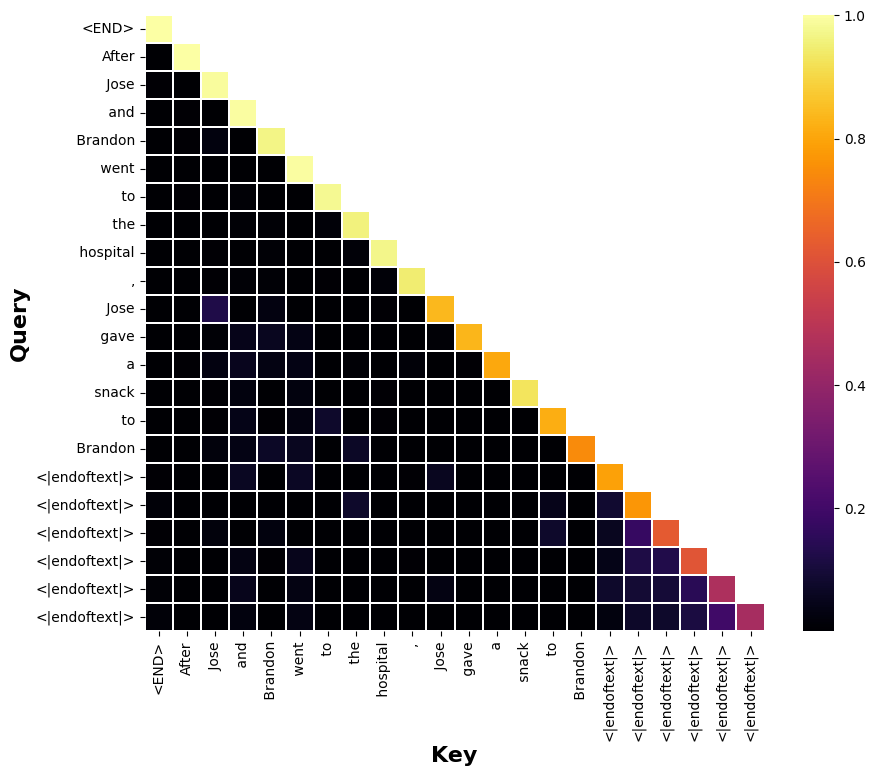

INDUCTION HEAD:
L5H5:


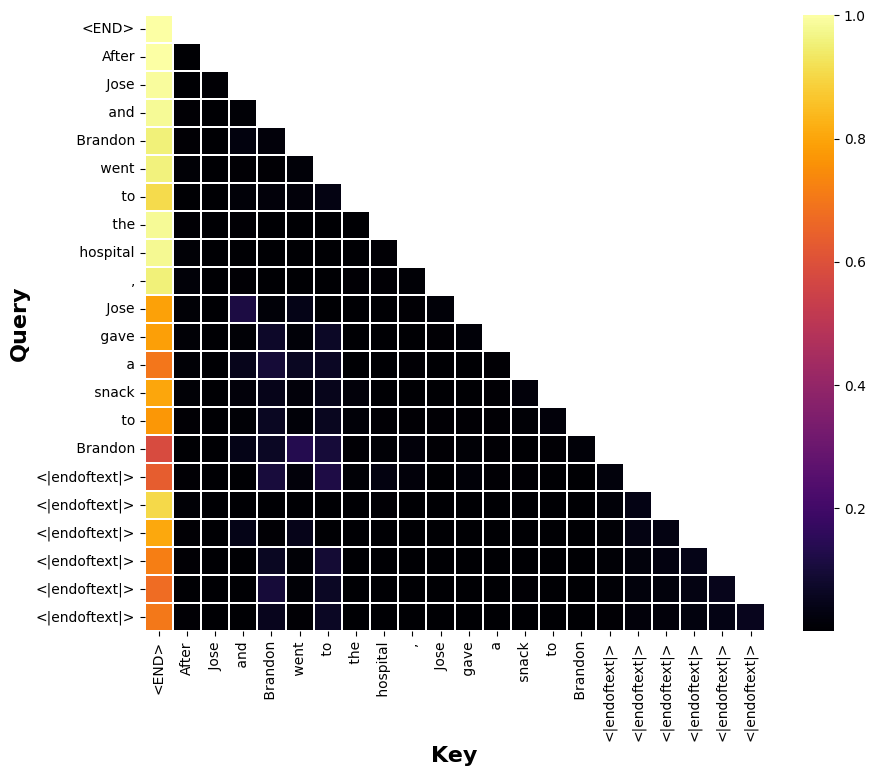

S-INHIBITION HEAD:
L8H10:


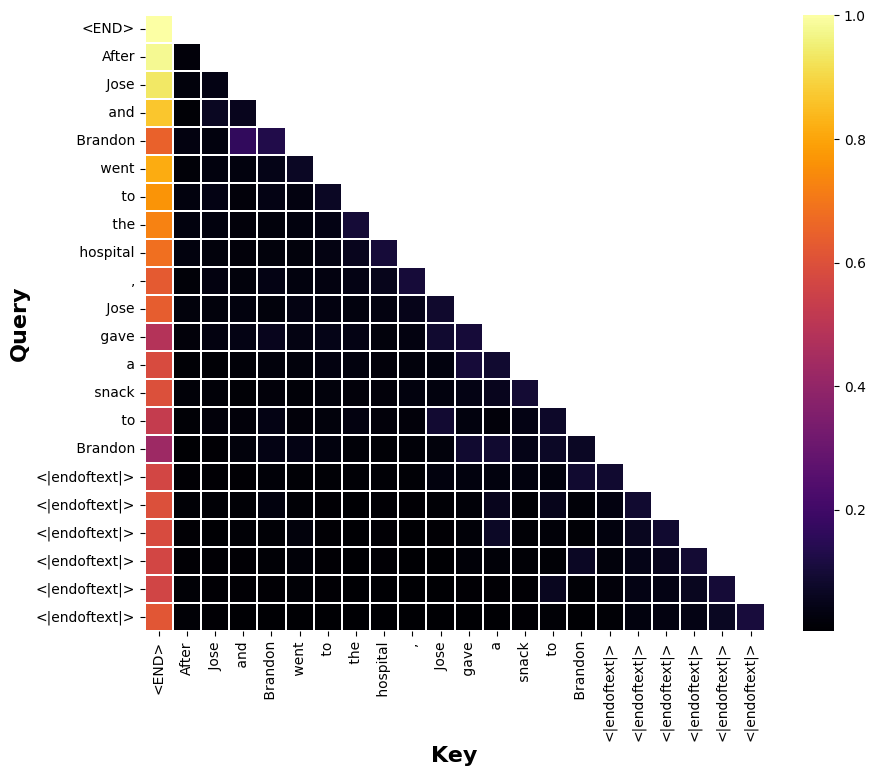

NEGATIVE NAME MOVER HEAD:
L10H7:


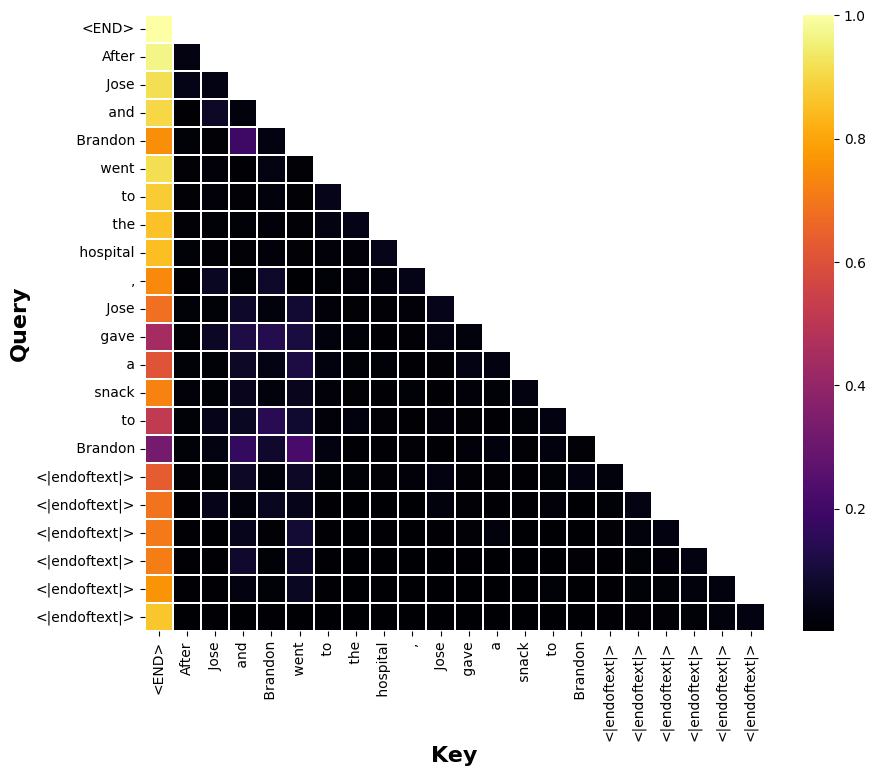

NAME MOVER HEAD:
L9H9:


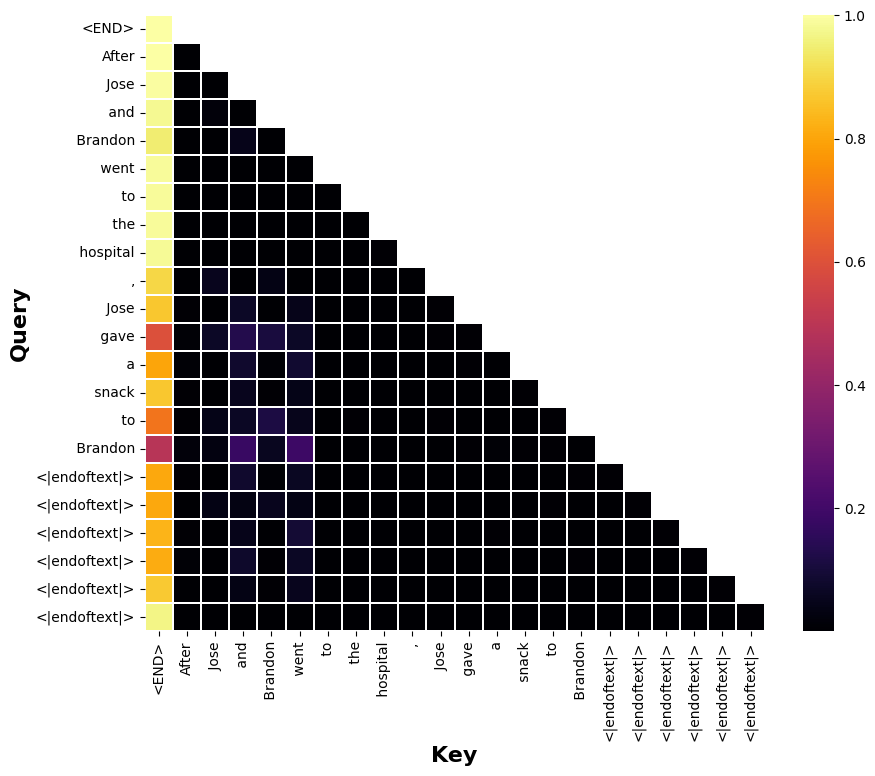

PREVIOUS TOKEN HEAD:
L4H11


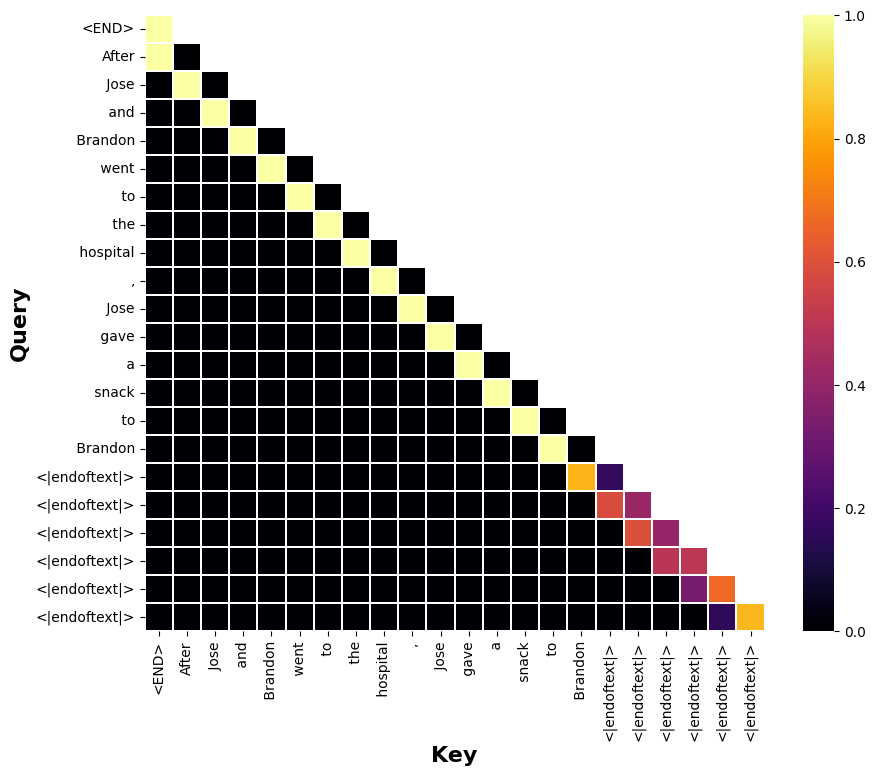

In [ ]:
def viz_attnPat_dupl_t(
    layer, head_index,
    highlightLines = False
):
    patterns = local_cache_t["attn", layer][:, head_index].mean(dim=0)
    patterns_np = patterns.cpu().numpy()

    str_tokens = teacher.to_str_tokens(tokens_t[36])
    str_tokens[0] = '<END>'

    mask = np.triu(np.ones_like(patterns_np, dtype=bool), k=1)

    plt.figure(figsize=(10, 8))
    ax = sns.heatmap(
        patterns_np,
        xticklabels=str_tokens,
        yticklabels=str_tokens,
        cmap = 'inferno',
        annot=False,
        fmt='.2f',
        linewidths=0.1,
        linecolor='white',
        mask=mask
    )

    ax.set_xlabel('Key', fontsize=16, fontweight='bold')
    ax.set_ylabel('Query', fontsize=16, fontweight='bold')

    if highlightLines:
        import matplotlib.patches as mpatches

        for i in range(0, 19):
            rect = mpatches.Rectangle((i, i), 1, 1, linewidth=3.5, edgecolor='lime', facecolor='none')
            ax.add_patch(rect)
            rect = mpatches.Rectangle((i, i+5), 1, 1, linewidth=3.5, edgecolor='lime', facecolor='none')
            ax.add_patch(rect)
            rect = mpatches.Rectangle((i, i+10), 1, 1, linewidth=3.5, edgecolor='lime', facecolor='none')
            ax.add_patch(rect)

    plt.show()

print("DUPLICATE TOKEN HEAD:")
print(f"L0H1:")
viz_attnPat_dupl_t(0, 1)
print("INDUCTION HEAD:")
print(f"L5H5:")
viz_attnPat_dupl_t(5, 5)
print("S-INHIBITION HEAD:")
print("L8H10:")
viz_attnPat_dupl_t(8, 10)
print("NEGATIVE NAME MOVER HEAD:")
print("L10H7:")
viz_attnPat_dupl_t(10, 7)
print("NAME MOVER HEAD:")
print("L9H9:")
viz_attnPat_dupl_t(9, 9)
print("PREVIOUS TOKEN HEAD:")
print("L4H11")
viz_attnPat_dupl_t(4, 11)


In [ ]:
import torch
import torch.nn.functional as F

sims = {}
max_vals_attn = {}

for teacher_layer in range(12):
    for teacher_head in range(12):
        curr_comb = (teacher_layer, teacher_head)
        if curr_comb not in max_vals_attn.keys():
            max_vals_attn[curr_comb] = (None, 0)
        for student_layer in range(6):
            for student_head in range(12):
                curr_s = local_cache_s["attn", student_layer][:, student_head].mean(dim=0)
                curr_t = local_cache_t["attn", teacher_layer][:, teacher_head].mean(dim=0)
                sim = torch.mean(F.cosine_similarity(curr_s.unsqueeze(1), curr_t.unsqueeze(1), dim=2))
                if sim >= max_vals_attn[curr_comb][1]:
                    max_vals_attn[curr_comb] = ((student_layer, student_head), sim)
                sims[(teacher_layer, teacher_head, student_layer, student_head)] = sim

mean_val = torch.mean(torch.stack(list(sims.values())))
print(f"Mean similarity across all heads: {mean_val}")


Mean similarity across all heads: 0.7588077187538147


In [ ]:
max_vals_attn[(7, 2)]

((3, 2), tensor(0.9995, device='cuda:0'))

=== duplicate token head, similarity: 0.9952082633972168 ===
TEACHER (L0H1):


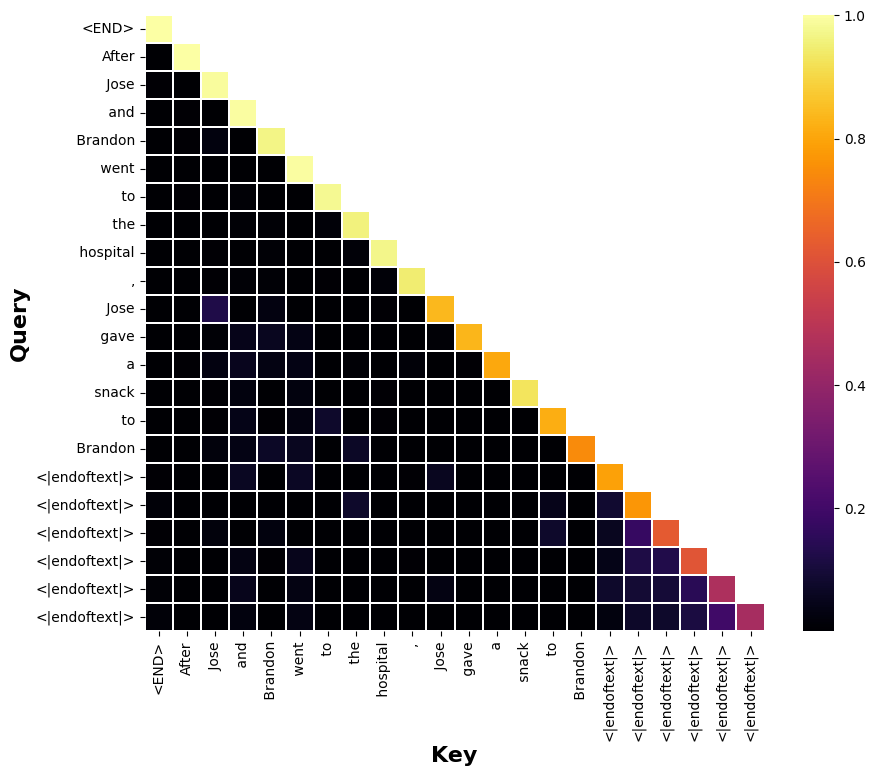

STUDENT (L0H5):


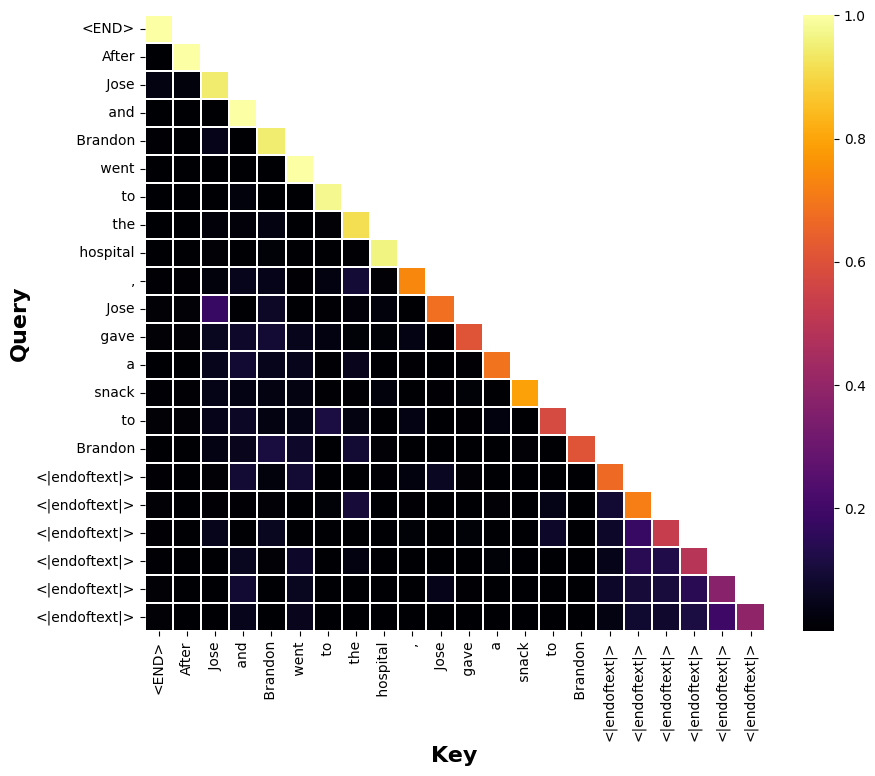

=== induction head, similarity: 0.9980992674827576 ===
TEACHER (L5H5):


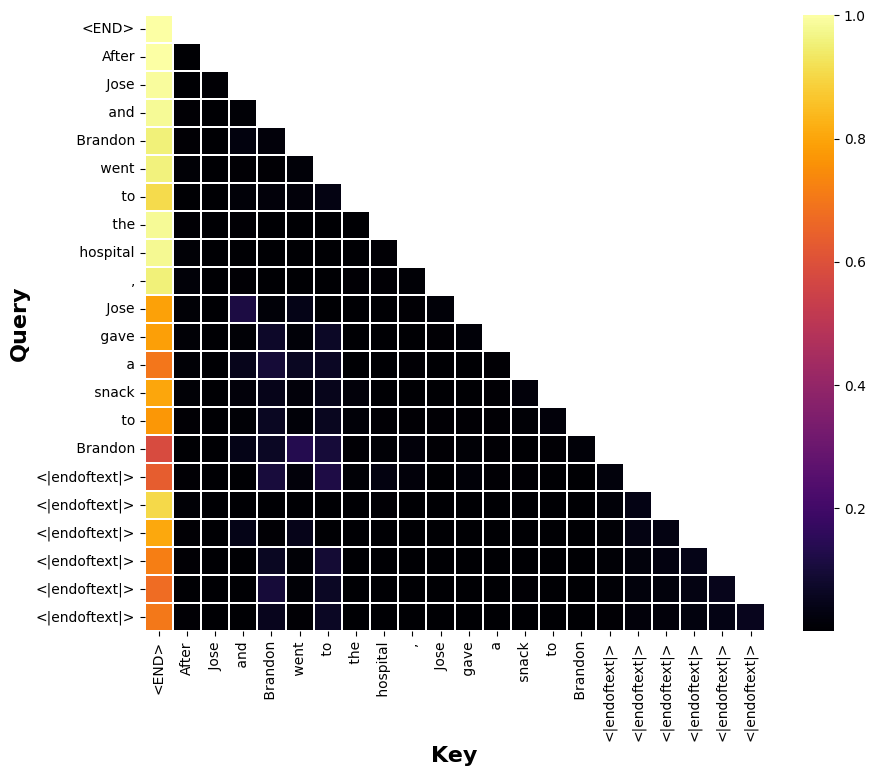

STUDENT (L3H10):


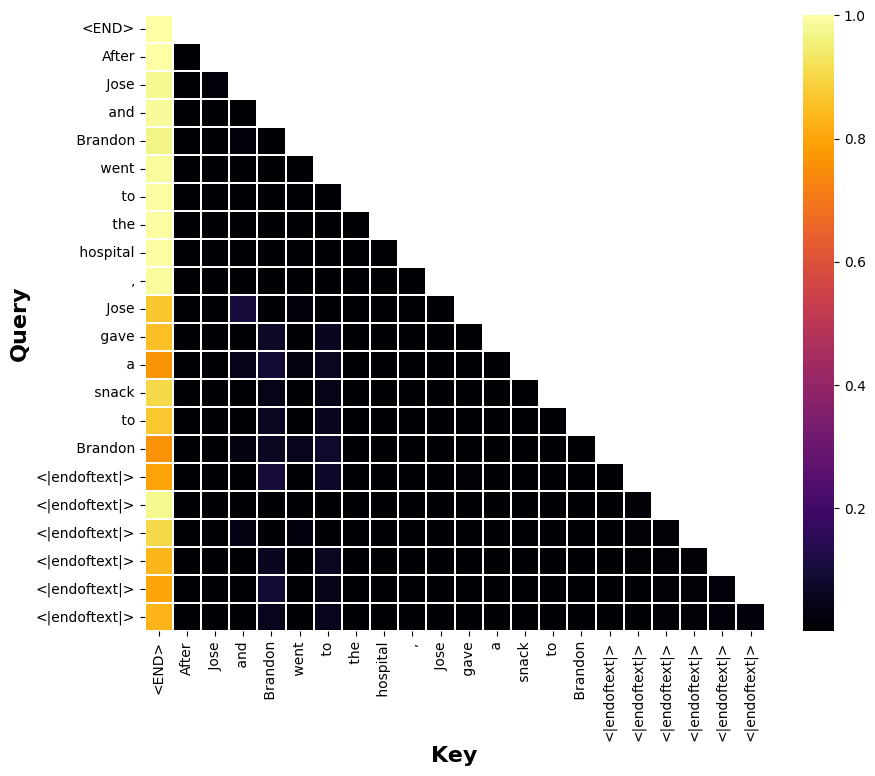

=== s-inhibition head, similarity: 0.9928016662597656 ===
TEACHER (L8H10):


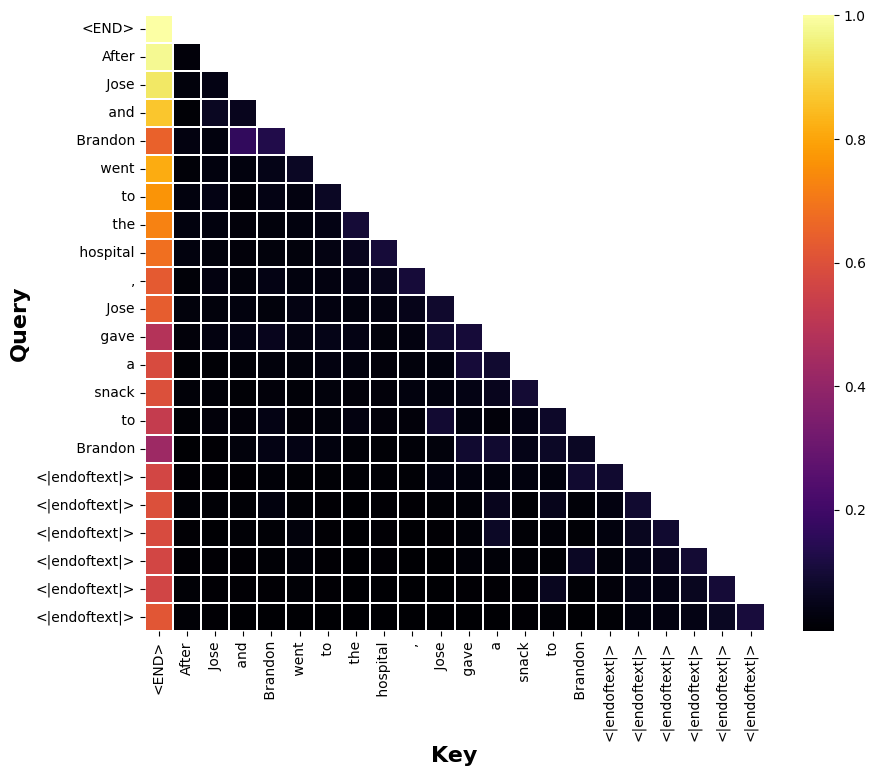

STUDENT (L3H3):


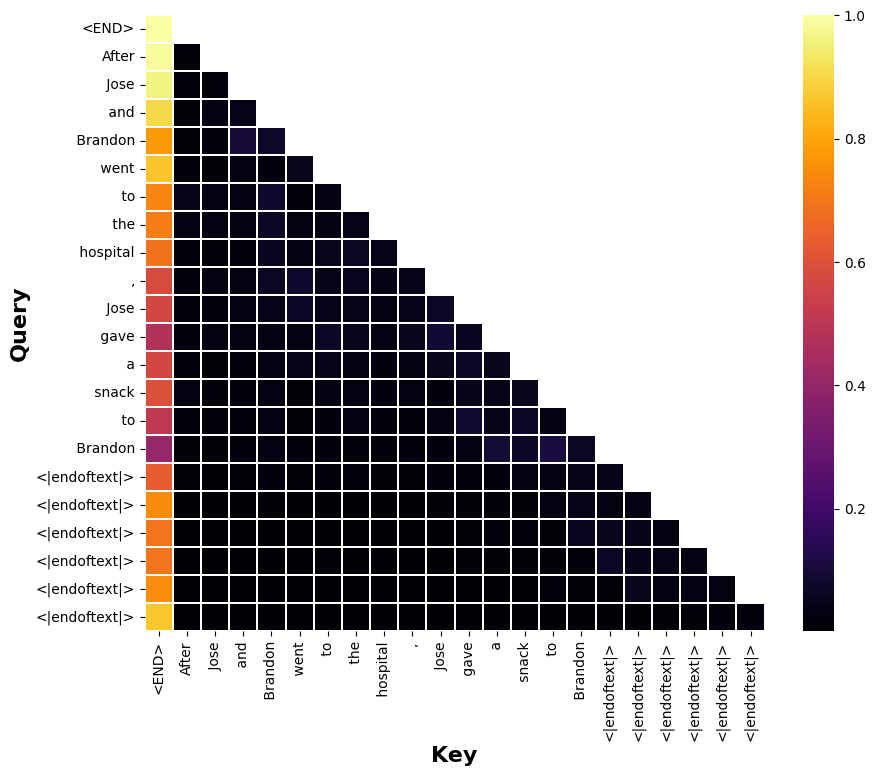

=== negative name mover head, similarity: 0.9912496209144592 ===
TEACHER (L10H7):


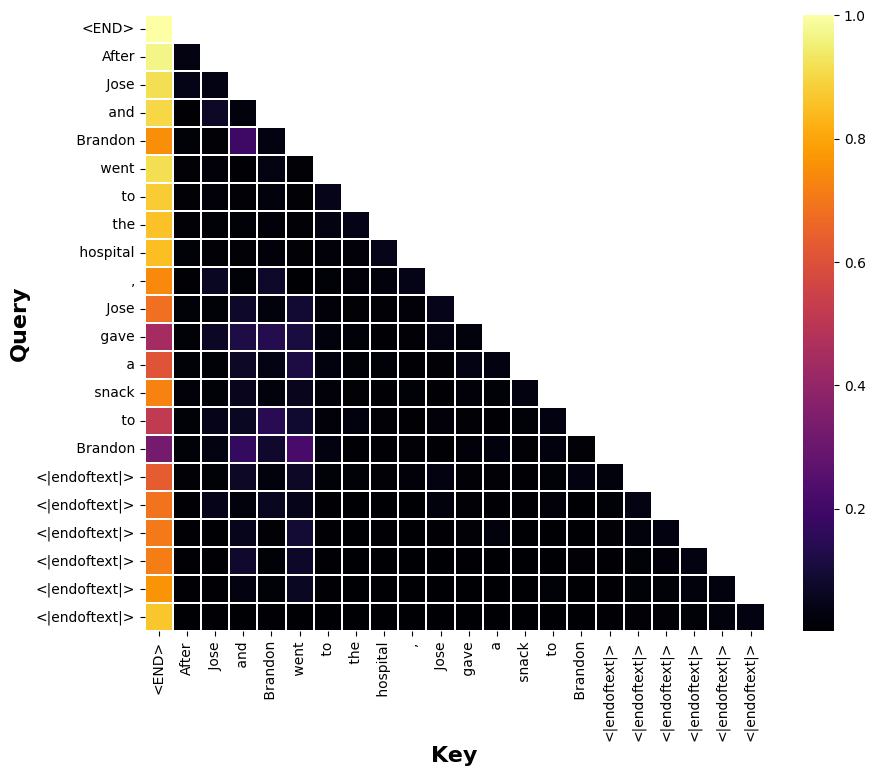

STUDENT (L5H1):


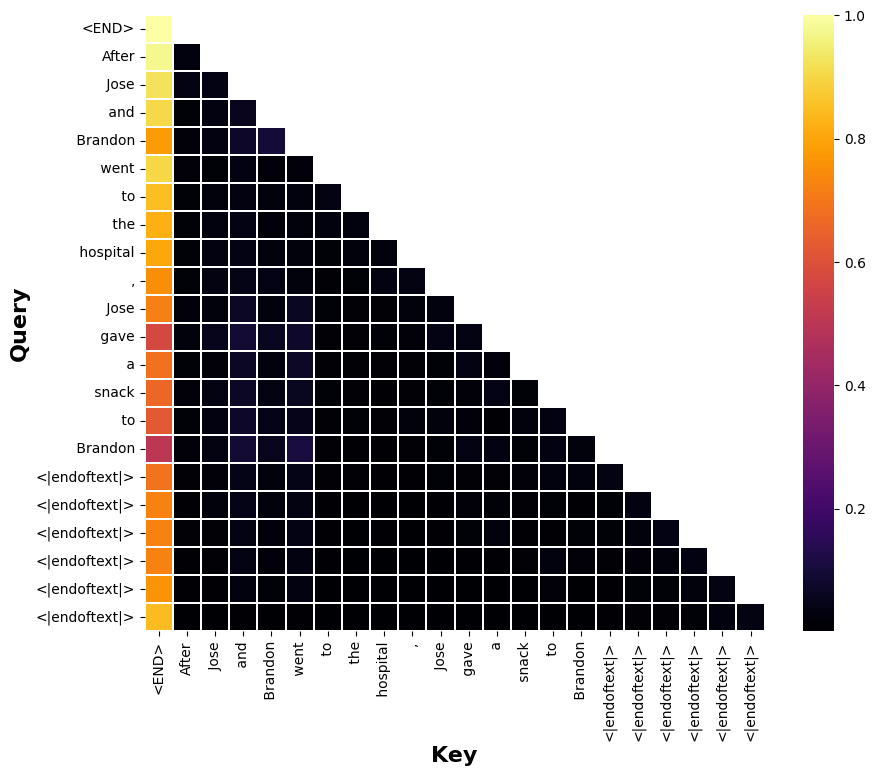

=== name mover head, similarity: 0.9976177215576172 ===
TEACHER (L9H9):


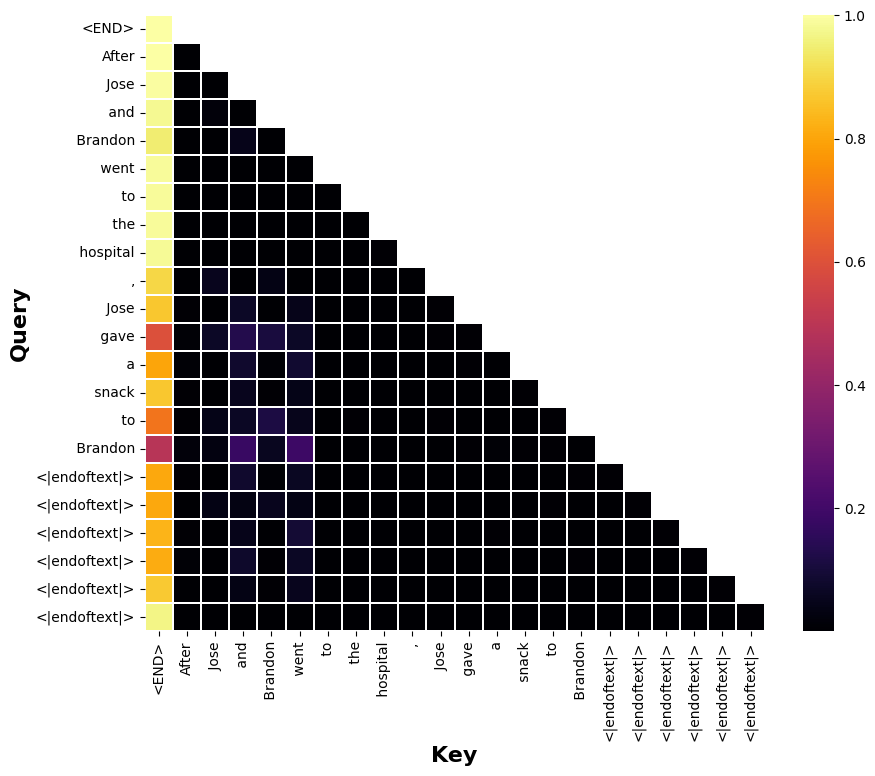

STUDENT (L5H2):


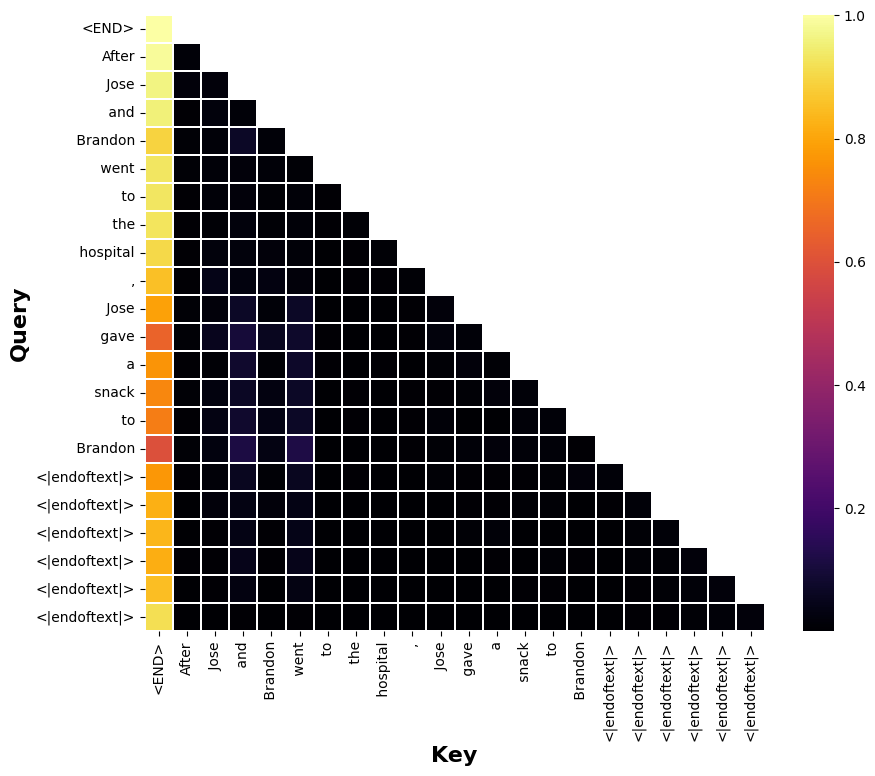

=== previous token head, similarity: 0.9897591471672058 ===
TEACHER (L4H11):


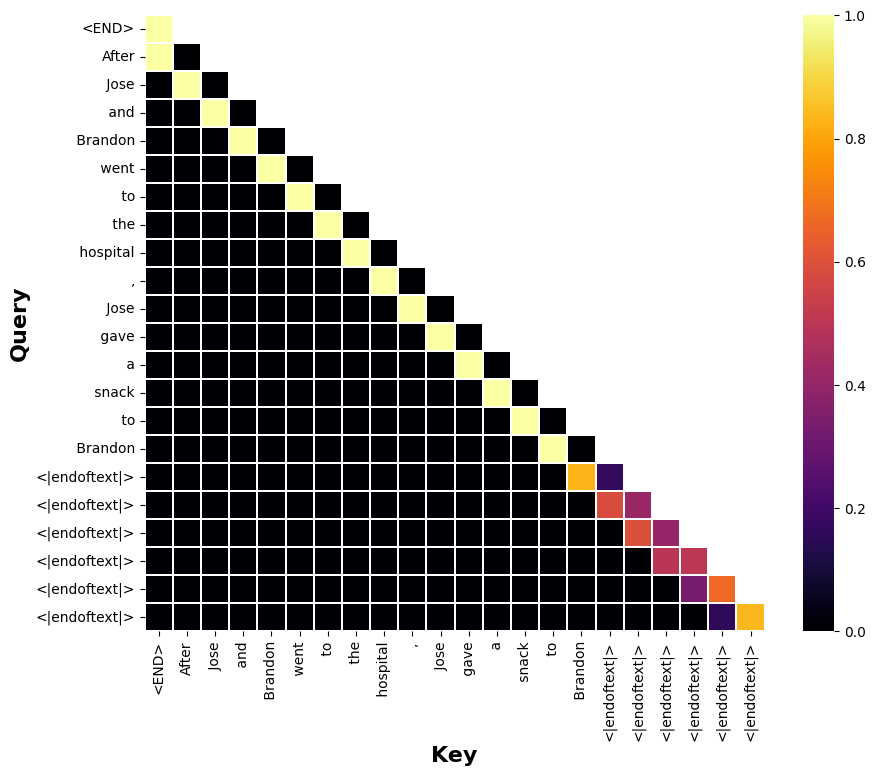

STUDENT (L2H11):


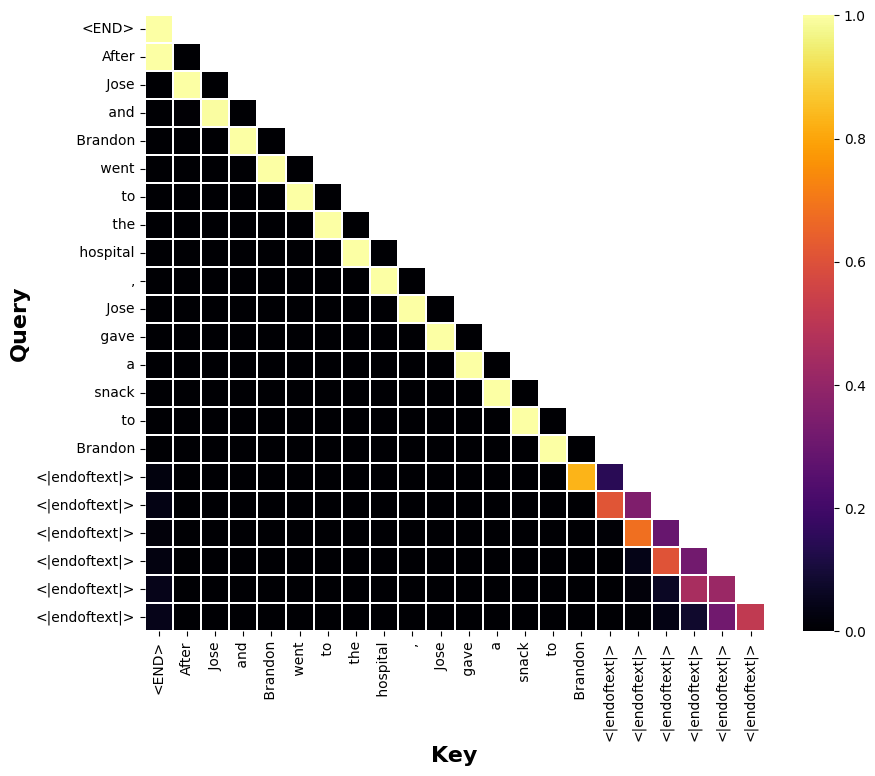

In [ ]:
def viz_attnPat_dupl_s(
    layer, head_index,
    highlightLines = False
):
    patterns = local_cache_s["attn", layer][:, head_index].mean(dim=0)
    patterns_np = patterns.cpu().numpy()

    str_tokens = student.to_str_tokens(tokens_s[36])
    str_tokens[0] = '<END>'

    mask = np.triu(np.ones_like(patterns_np, dtype=bool), k=1)

    plt.figure(figsize=(10, 8))
    ax = sns.heatmap(
        patterns_np,
        xticklabels=str_tokens,
        yticklabels=str_tokens,
        cmap = 'inferno',
        annot=False,
        fmt='.2f',
        linewidths=0.1,
        linecolor='white',
        mask=mask
    )

    ax.set_xlabel('Key', fontsize=16, fontweight='bold')
    ax.set_ylabel('Query', fontsize=16, fontweight='bold')

    if highlightLines:
        import matplotlib.patches as mpatches

        for i in range(0, 19):
            rect = mpatches.Rectangle((i, i), 1, 1, linewidth=3.5, edgecolor='lime', facecolor='none')
            ax.add_patch(rect)
            rect = mpatches.Rectangle((i, i+5), 1, 1, linewidth=3.5, edgecolor='lime', facecolor='none')
            ax.add_patch(rect)
            rect = mpatches.Rectangle((i, i+10), 1, 1, linewidth=3.5, edgecolor='lime', facecolor='none')
            ax.add_patch(rect)

    plt.show()

heads = [((0, 1), "duplicate token head"), ((5, 5), "induction head"), ((8, 10), "s-inhibition head"), ((10, 7), "negative name mover head"), ((9, 9), "name mover head"), ((4, 11), "previous token head")]

for head in heads:
  student_match = max_vals_attn[(head[0][0], head[0][1])]

  student_match_component = student_match[0]

  if student_match is not None:
    print(f"=== {head[1]}, similarity: {student_match[1]} ===")
    print(f"TEACHER (L{head[0][0]}H{head[0][1]}):")
    viz_attnPat_dupl_t(head[0][0], head[0][1])
    print(f"STUDENT (L{student_match_component[0]}H{student_match_component[1]}):")
    viz_attnPat_dupl_s(student_match_component[0], student_match_component[1])
    print("==================")
  else:
    print(f"==== No matching student head found for teacher head {head[0]} ({head[1]}) ====")


# Node Pruning

In [ ]:
%cd ../../../../../../../../../../../content
%ls

/content
sample_data/  seqcont_circ_expms/


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import einops
from fancy_einsum import einsum
import tqdm.notebook as tqdm
import random
from pathlib import Path
from torch.utils.data import DataLoader

from jaxtyping import Float, Int
from typing import List, Union, Optional
from functools import partial
import copy

import itertools
from transformers import AutoModelForCausalLM, AutoConfig, AutoTokenizer
import dataclasses
import datasets
from IPython.display import HTML

import pickle
from google.colab import files

import matplotlib.pyplot as plt
import statistics

In [ ]:
import transformer_lens
import transformer_lens.utils as utils
from transformer_lens.hook_points import (
    HookedRootModule,
    HookPoint,
)
from transformer_lens import HookedTransformer, HookedTransformerConfig, FactoredMatrix, ActivationCache

In [ ]:
torch.set_grad_enabled(False)

In [ ]:
!git clone https://github.com/apartresearch/seqcont_circuits.git

Cloning into 'seqcont_circuits'...
remote: Enumerating objects: 1098, done.
remote: Counting objects: 100% (41/41), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 1098 (delta 30), reused 21 (delta 21), pack-reused 1057 (from 1)
Receiving objects: 100% (1098/1098), 20.04 MiB | 22.68 MiB/s, done.
Resolving deltas: 100% (739/739), done.


In [ ]:
%cd seqcont_circuits/src/iter_node_pruning
from dataset import Dataset
%cd ..
from generate_data import *
%cd iter_node_pruning
from metrics import *
from head_ablation_fns import *
from mlp_ablation_fns import *
from node_ablation_fns import *
from loop_node_ablation_fns import *

/content/seqcont_circuits/src/iter_node_pruning
/content/seqcont_circuits/src
/content/seqcont_circuits/src/iter_node_pruning


In [ ]:
def get_logit_diff_new(logits, dataset):
    io_logits = logits[torch.arange(N), dataset.word_idx["end"], dataset.io_tokenIDs]
    s_logits = logits[torch.arange(N), dataset.word_idx["end"], dataset.s_tokenIDs]
    return (io_logits - s_logits).mean().item()

In [ ]:
teacher.reset_hooks(including_permanent=True)
student.reset_hooks(including_permanent=True)

logits_original_teacher = teacher(ioi_dataset.toks)
logits_original_student = student(ioi_dataset.toks)

orig_score_t = get_logit_diff_new(logits_original_teacher, ioi_dataset)
orig_score_s = get_logit_diff_new(logits_original_student, ioi_dataset)

In [ ]:
orig_score_t, orig_score_s

(3.465851306915283, -0.2311263233423233)

In [ ]:
import gc

del(logits_original_teacher)
del(logits_original_student)
torch.cuda.empty_cache()
gc.collect()

289

In [ ]:
dataset = ioi_dataset
dataset_2 = abc_dataset

In [ ]:
def direct_ablate_single_head(
    model: HookedTransformer,
    dataset: Dataset,
    layer: int,
    head: int,
    orig_score: float,
    ablation_type="zero",
    print_output: bool = True
) -> float:
    model.reset_hooks(including_permanent=True)

    if ablation_type == "mean":
        _, cache = model.run_with_cache(
            dataset.toks.long(),
            return_type=None,
            names_filter=lambda name: name.endswith("z") and f"blocks.{layer}" in name
        )
        z_mean = cache[utils.get_act_name("z", layer)].mean(dim=0, keepdim=True)

    def hook_fn(z, hook):
        if hook.layer() == layer:
            z_modified = z.clone()
            if ablation_type == "zero":
                z_modified[:, :, head] = 0
                z_modified[:, :, head] = z_mean.expand_as(z[:, :, head])
            return z_modified
        return z

    model.add_hook(lambda name: name.endswith("z"), hook_fn, is_permanent=False)

    ablated_logits = model(dataset.toks)

    new_score = get_logit_diff_new(ablated_logits, dataset)

    percent_retained = 100 * (new_score / orig_score)

    if print_output:
        impact = 100 - percent_retained
        print(f"Layer {layer}, Head {head}: Impact = {impact:.2f}%, Retained = {percent_retained:.2f}%")

    model.reset_hooks()
    return percent_retained

student_scores = {}
for layer in range(6):
    for head in range(12):
        retained = direct_ablate_single_head(
            student, dataset, layer, head, orig_score_s, ablation_type="zero"
        )
        student_scores[(layer, head)] = retained

teacher_scores = {}
for layer in range(12):
    for head in range(12):
        retained = direct_ablate_single_head(
            teacher, dataset, layer, head, orig_score_t, ablation_type="zero"
        )
        teacher_scores[(layer, head)] = retained



Layer 0, Head 0: Impact = 14.77%, Retained = 85.23%
Layer 0, Head 1: Impact = -73.05%, Retained = 173.05%
Layer 0, Head 2: Impact = 32.49%, Retained = 67.51%
Layer 0, Head 3: Impact = -1.81%, Retained = 101.81%
Layer 0, Head 4: Impact = 8.12%, Retained = 91.88%
Layer 0, Head 5: Impact = -100.97%, Retained = 200.97%
Layer 0, Head 6: Impact = 29.52%, Retained = 70.48%
Layer 0, Head 7: Impact = 72.28%, Retained = 27.72%
Layer 0, Head 8: Impact = -37.33%, Retained = 137.33%
Layer 0, Head 9: Impact = -115.93%, Retained = 215.93%
Layer 0, Head 10: Impact = -109.62%, Retained = 209.62%
Layer 0, Head 11: Impact = -82.19%, Retained = 182.19%
Layer 1, Head 0: Impact = -20.04%, Retained = 120.04%
Layer 1, Head 1: Impact = 44.91%, Retained = 55.09%
Layer 1, Head 2: Impact = 15.56%, Retained = 84.44%
Layer 1, Head 3: Impact = -11.49%, Retained = 111.49%
Layer 1, Head 4: Impact = -17.68%, Retained = 117.68%
Layer 1, Head 5: Impact = -18.69%, Retained = 118.69%
Layer 1, Head 6: Impact = 24.41%, Retai

In [ ]:
lh_scores_t = teacher_scores
lh_scores_s = student_scores

sorted_lh_scores_t = sorted(lh_scores_t.items(), key=lambda item: -item[1], reverse=True)
modified_scores_t = []

sorted_lh_scores_s = sorted(lh_scores_s.items(), key=lambda item: -item[1], reverse=True)
modified_scores_s = []

for lh, score in sorted_lh_scores_t:
    modified_score = -round(100 - score, 2)
    modified_scores_t.append((lh, modified_score))
scores_attn_t = modified_scores_t

for lh, score in sorted_lh_scores_s:
    modified_score = -round(100 - score, 2)
    modified_scores_s.append((lh, modified_score))
scores_attn_s = modified_scores_s

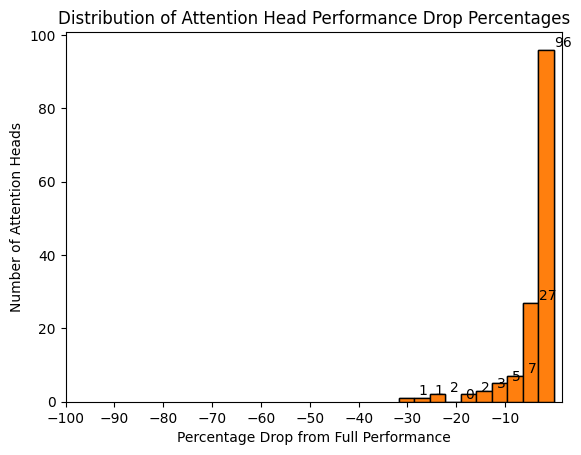

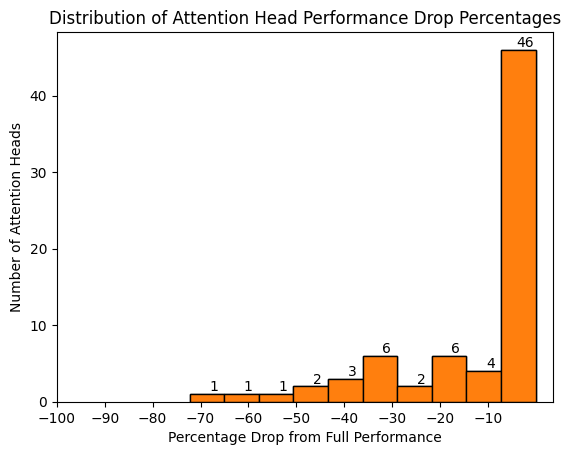

In [ ]:
lh_scores_drop = {key: min(0, val-100) for key, val in lh_scores_t.items()}
scores = list(lh_scores_drop.values())
scores = [s.cpu().numpy() if isinstance(s, torch.Tensor) else s for s in scores]
plt.hist(scores, bins=10, edgecolor='black')
n, bins, patches = plt.hist(scores, bins=10, edgecolor='black')

for i in range(len(n)):
    plt.text(bins[i]+5, n[i], str(int(n[i])), va='bottom', ha='center')

plt.xticks(range(-100, 0, 10))
plt.xlabel('Percentage Drop from Full Performance')
plt.ylabel('Number of Attention Heads')
plt.title('Distribution of Attention Head Performance Drop Percentages')

plt.show()

lh_scores_drop = {key: min(0, val-100) for key, val in lh_scores_s.items()}
scores = list(lh_scores_drop.values())
scores = [s.cpu().numpy() if isinstance(s, torch.Tensor) else s for s in scores]
plt.hist(scores, bins=10, edgecolor='black')
n, bins, patches = plt.hist(scores, bins=10, edgecolor='black')

for i in range(len(n)):
    plt.text(bins[i]+5, n[i], str(int(n[i])), va='bottom', ha='center')

plt.xticks(range(-100, 0, 10))
plt.xlabel('Percentage Drop from Full Performance')
plt.ylabel('Number of Attention Heads')
plt.title('Distribution of Attention Head Performance Drop Percentages')

plt.show()

In [ ]:
def direct_ablate_single_mlp(
    model: HookedTransformer,
    dataset: Dataset,
    layer: int,
    orig_score: float,
    ablation_type="zero",
    print_output: bool = True
) -> float:
    model.reset_hooks(including_permanent=True)

    if ablation_type == "mean":
        _, cache = model.run_with_cache(
            dataset.toks.long(),
            return_type=None,
            names_filter=lambda name: name.endswith("mlp_out") and f"blocks.{layer}" in name
        )
        mlp_mean = cache[utils.get_act_name("mlp_out", layer)].mean(dim=0, keepdim=True)

    def hook_fn(mlp_out, hook):
        if hook.layer() == layer:
            if ablation_type == "zero":
                return torch.zeros_like(mlp_out)
            else:
                return mlp_mean.expand_as(mlp_out)
        return mlp_out

    model.add_hook(lambda name: name.endswith("mlp_out"), hook_fn, is_permanent=False)

    ablated_logits = model(dataset.toks)

    new_score = get_logit_diff_new(ablated_logits, dataset)

    percent_retained = 100 * (new_score / orig_score)

    if print_output:
        impact = 100 - percent_retained
        print(f"Layer {layer} MLP: Impact = {impact:.2f}%, Retained = {percent_retained:.2f}%")

    model.reset_hooks()
    return percent_retained


scores_mlp_t = []
scores_mlp_s = []

print("Analyzing teacher model MLPs...")
for layer in range(12):
    retained = max(0, direct_ablate_single_mlp(teacher, dataset, layer, orig_score_t, ablation_type="zero", print_output=False))
    try:
      scores_mlp_t.append((layer, -round(100 - retained.item(), 2)))
    except:
      scores_mlp_t.append((layer, -round(100 - retained, 2)))
    print(f"Completed Layer {layer} MLP: Retained = {retained:.2f}%")

print("\nAnalyzing student model MLPs...")
for layer in range(6):
    retained = max(0, direct_ablate_single_mlp(student, dataset, layer, orig_score_s, ablation_type="zero", print_output=False))
    try:
      scores_mlp_s.append((layer, -round(100 - retained.item(), 2)))
    except:
      scores_mlp_s.append((layer, -round(100 - retained, 2)))
    print(f"Completed Layer {layer} MLP: Retained = {retained:.2f}%")


Analyzing teacher model MLPs...
Completed Layer 0 MLP: Retained = 0.00%
Completed Layer 1 MLP: Retained = 93.03%
Completed Layer 2 MLP: Retained = 93.19%
Completed Layer 3 MLP: Retained = 91.70%
Completed Layer 4 MLP: Retained = 75.03%
Completed Layer 5 MLP: Retained = 84.19%
Completed Layer 6 MLP: Retained = 86.78%
Completed Layer 7 MLP: Retained = 95.87%
Completed Layer 8 MLP: Retained = 112.94%
Completed Layer 9 MLP: Retained = 113.37%
Completed Layer 10 MLP: Retained = 78.41%
Completed Layer 11 MLP: Retained = 106.57%

Analyzing student model MLPs...
Completed Layer 0 MLP: Retained = 556.06%
Completed Layer 1 MLP: Retained = 297.15%
Completed Layer 2 MLP: Retained = 367.34%
Completed Layer 3 MLP: Retained = 115.41%
Completed Layer 4 MLP: Retained = 0.00%
Completed Layer 5 MLP: Retained = 185.14%


# Analyze heads

In [ ]:
def viz_attnPat_dupl(
    layer, head_index,
    highlightLines = True
):
    patterns = local_cache1["attn", layer][:, head_index].mean(dim=0)
    patterns_np = patterns.cpu().numpy()

    str_tokens = model.to_str_tokens(tokens[0])
    str_tokens[0] = '<END>'

    mask = np.triu(np.ones_like(patterns_np, dtype=bool), k=1)

    plt.figure(figsize=(10, 8))
    ax = sns.heatmap(
        patterns_np,
        xticklabels=str_tokens,
        yticklabels=str_tokens,
        cmap = 'inferno',
        annot=False,
        fmt='.2f',
        linewidths=0.1,
        linecolor='white',
        mask=mask
    )

    ax.set_xlabel('Key', fontsize=16, fontweight='bold')
    ax.set_ylabel('Query', fontsize=16, fontweight='bold')

    if highlightLines:
        import matplotlib.patches as mpatches

        for i in range(0, 19):
            rect = mpatches.Rectangle((i, i), 1, 1, linewidth=3.5, edgecolor='lime', facecolor='none')
            ax.add_patch(rect)
            rect = mpatches.Rectangle((i, i+5), 1, 1, linewidth=3.5, edgecolor='lime', facecolor='none')
            ax.add_patch(rect)
            rect = mpatches.Rectangle((i, i+10), 1, 1, linewidth=3.5, edgecolor='lime', facecolor='none')
            ax.add_patch(rect)

    plt.show()


viz_attnPat_dupl(9, 6)
